True argmax: 2.6386, True max value: 1.5258


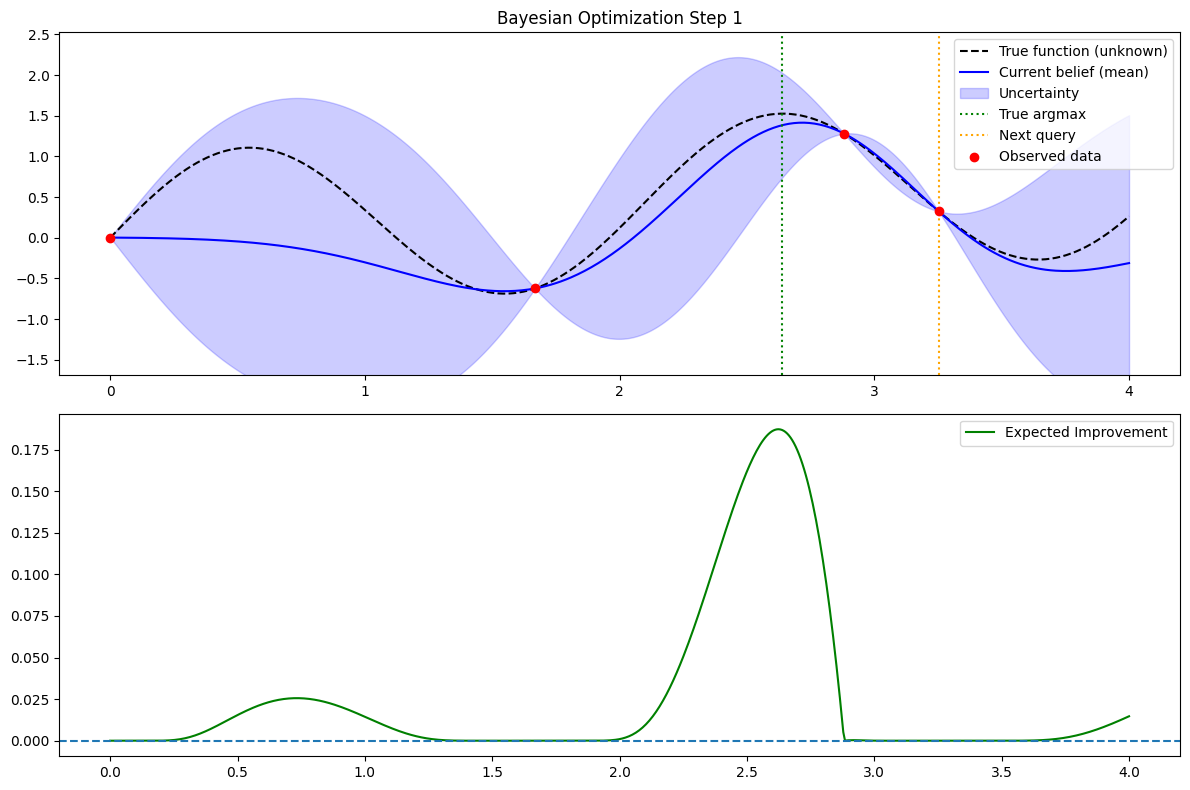

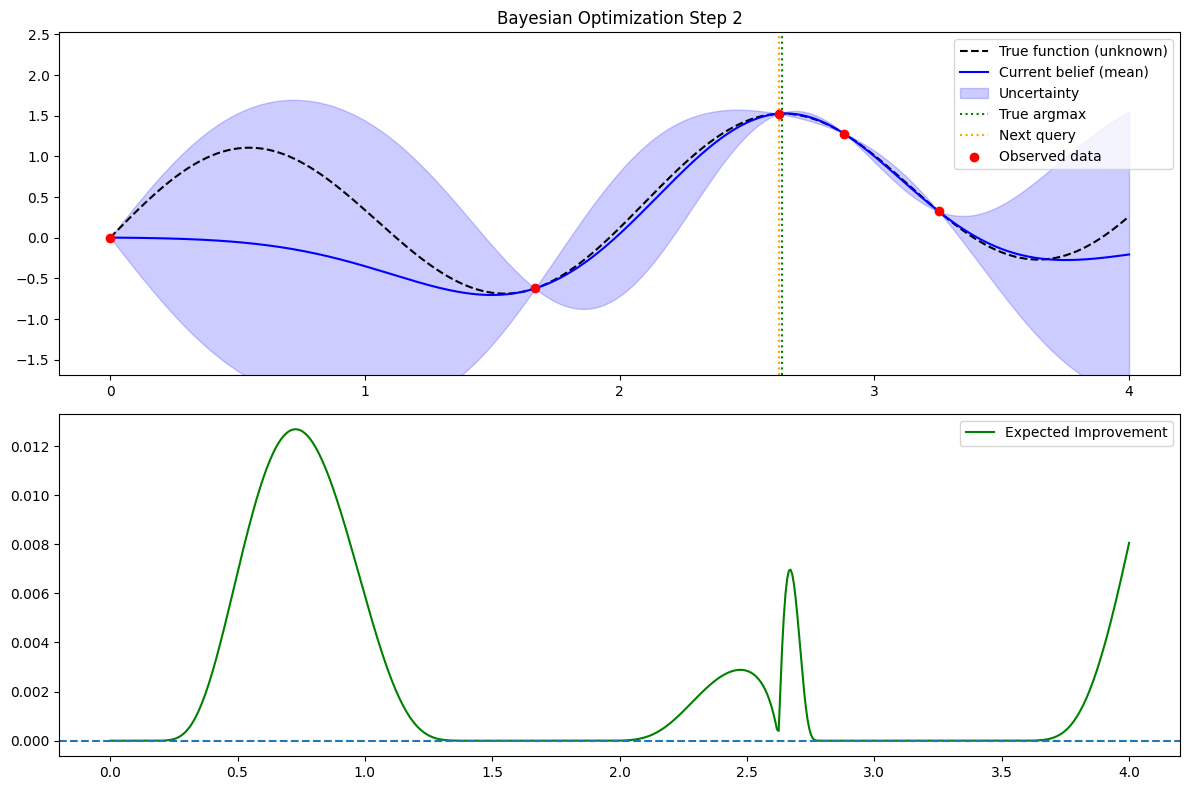

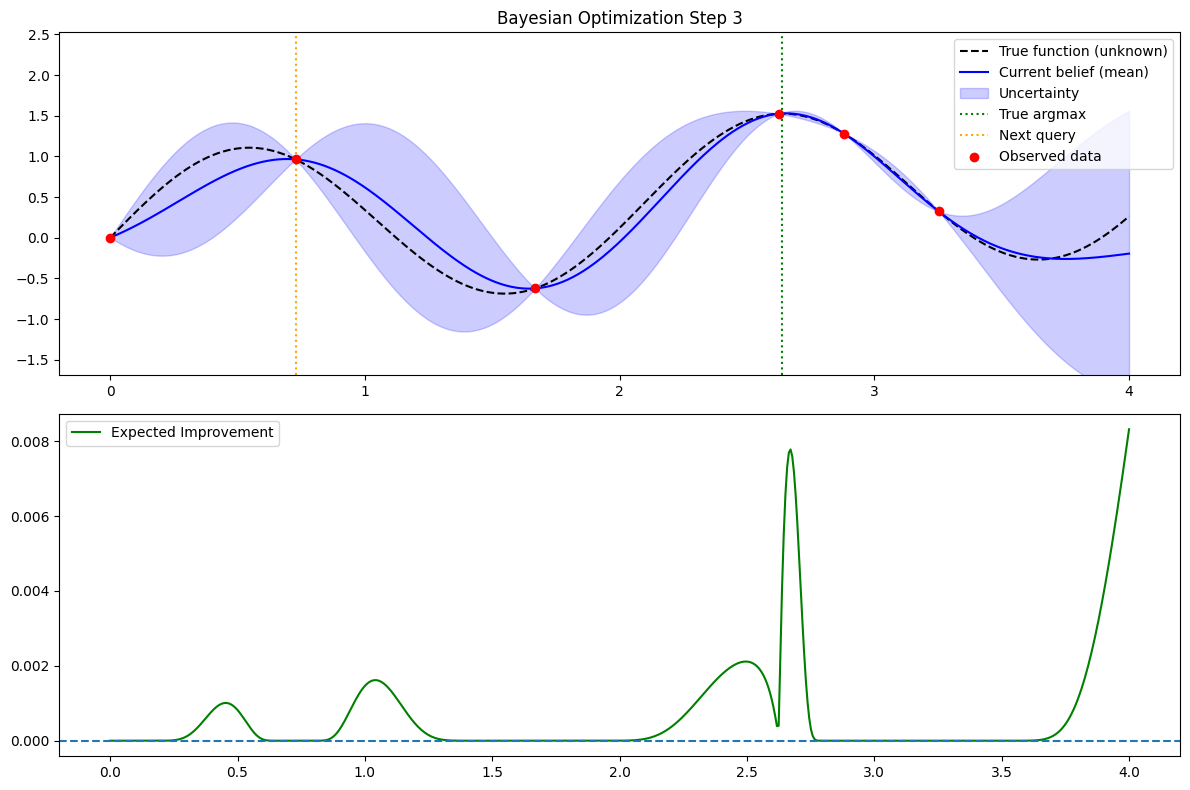

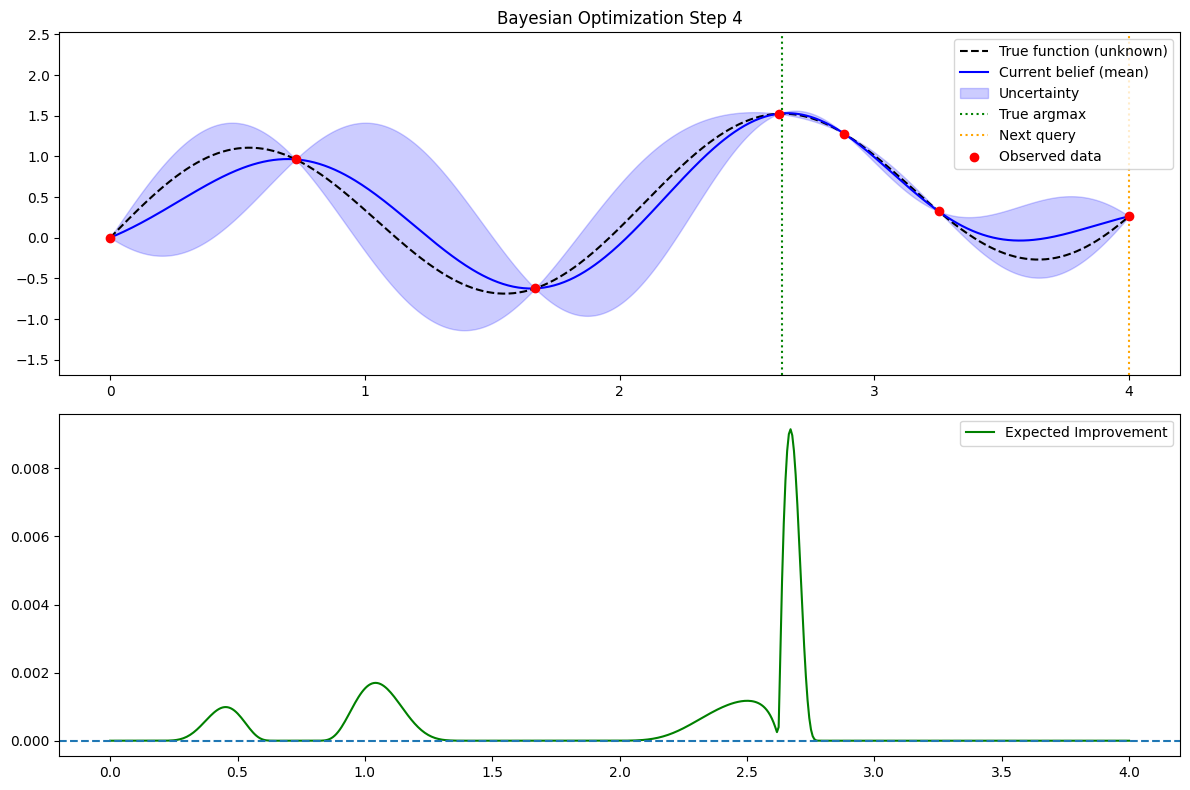

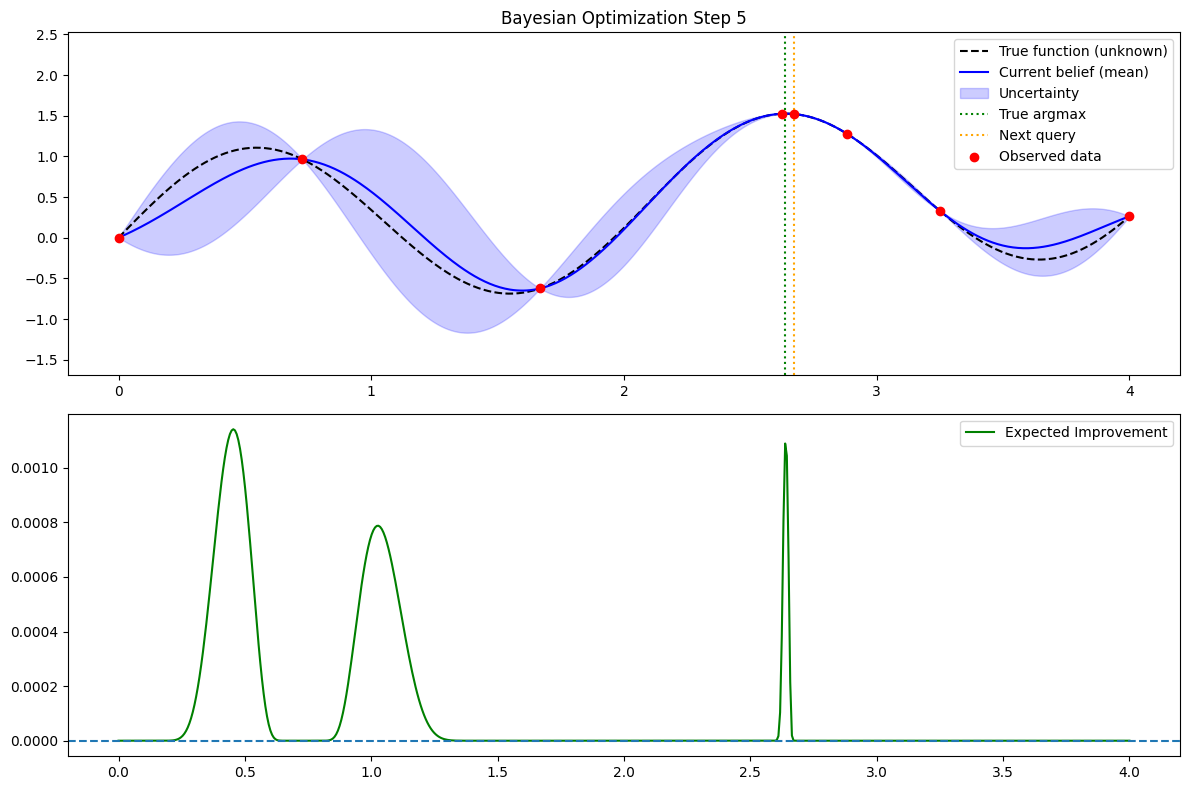

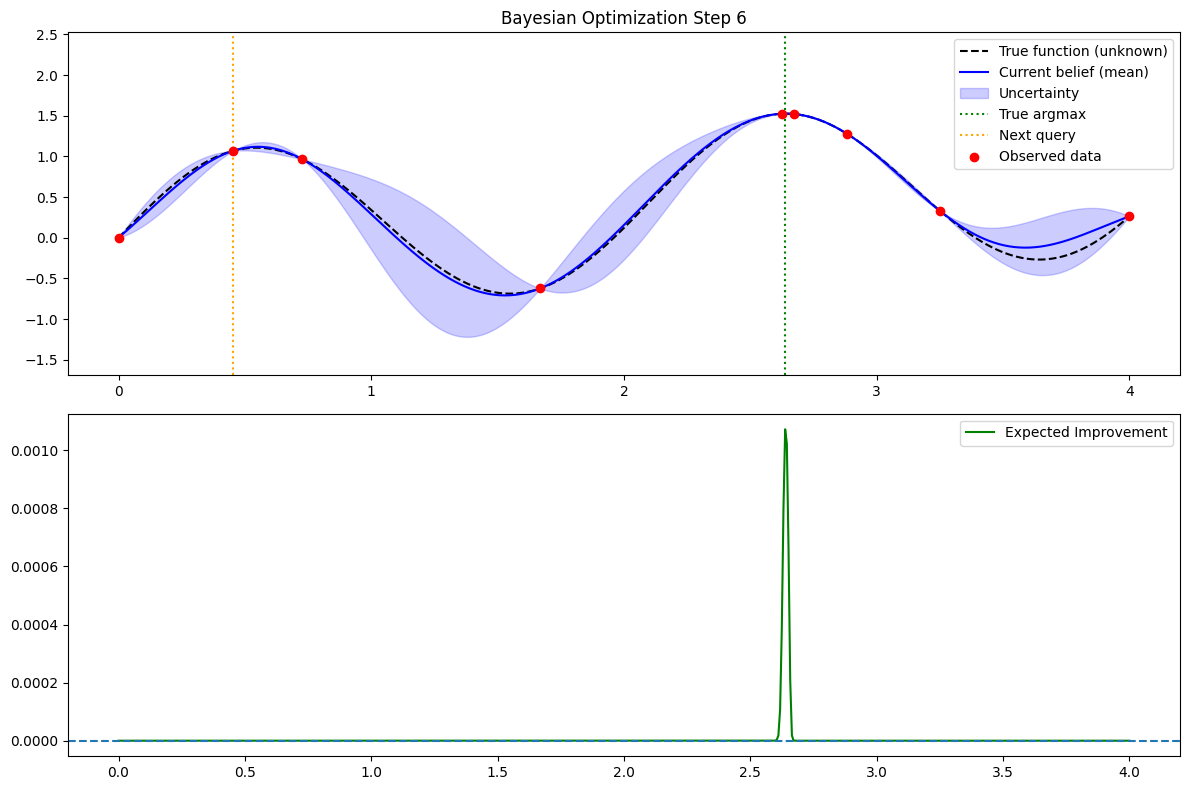

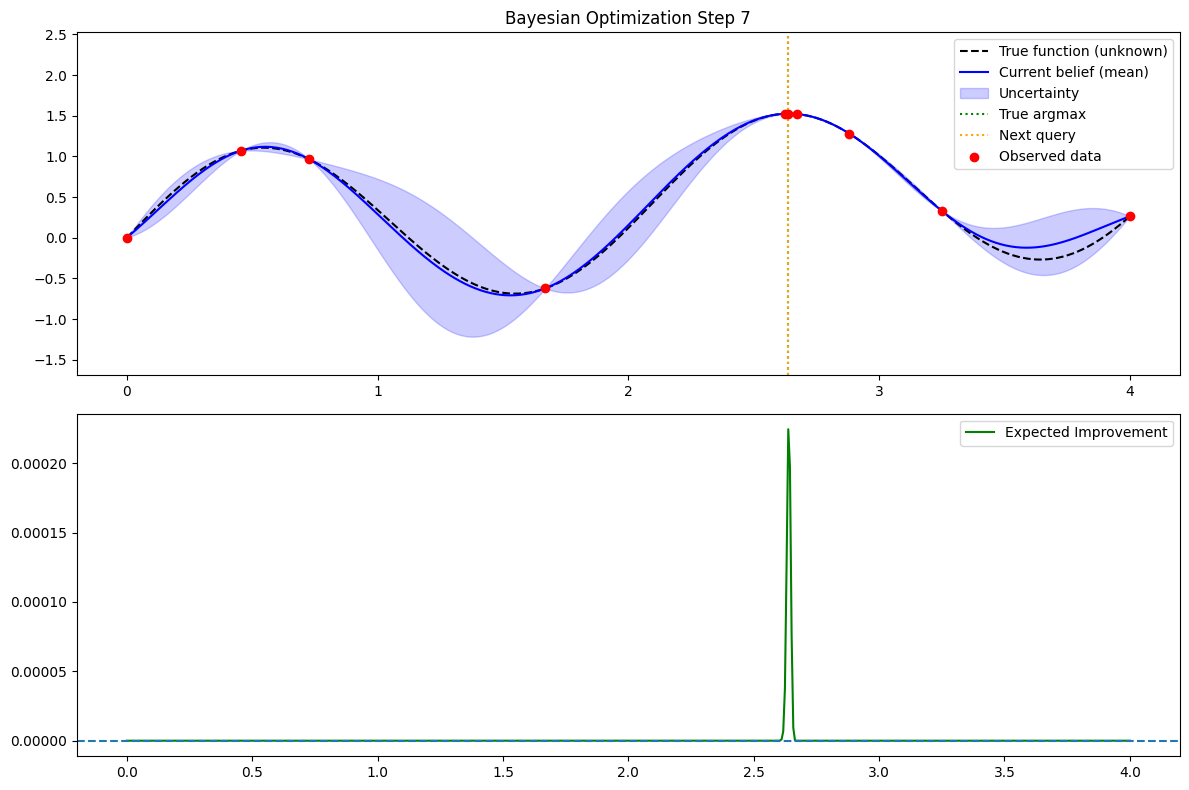

Converged at step 8


In [2]:
import matplotlib.pyplot as plt
import numpy as np

BOUNDS = (0, 4)

# ==========================
# 1. TRUE UNKNOWN FUNCTION
# ==========================


# This is the "real world".
# The optimizer does NOT know this formula.
def true_function(theta):
    return np.sin(3 * theta) + 0.2 * theta


def true_arg_max_theta():
    # grid search to find true argmax for reference
    theta_grid = np.linspace(BOUNDS[0], BOUNDS[1], 1000)
    y_grid = true_function(theta_grid)
    return theta_grid[np.argmax(y_grid)]


# ==========================
# 2. KERNEL (belief mechanism)
# ==========================


def rbf_kernel(x1, x2, length_scale=0.5):
    """
    Radial basis function kernel.
    Measures similarity between points.
    """
    x1 = x1[:, None]
    x2 = x2[None, :]
    return np.exp(-0.5 * (x1 - x2) ** 2 / length_scale**2)


# ==========================
# 3. BELIEF UPDATE
# ==========================


def belief_predict(X_train, y_train, X_query, noise=1e-6):
    """
    Given dataset D_n = {(theta_i, y_i)},
    compute belief (mean and uncertainty).

    This is Bayesian update logic implemented with numpy.
    """

    if len(X_train) == 0:
        # prior: zero mean, high uncertainty
        mu = np.zeros_like(X_query)
        sigma = np.ones_like(X_query)
        return mu, sigma

    K = rbf_kernel(X_train, X_train) + noise * np.eye(len(X_train))
    K_s = rbf_kernel(X_train, X_query)
    K_ss = rbf_kernel(X_query, X_query)

    K_inv = np.linalg.inv(K)

    # Posterior mean
    mu = K_s.T @ K_inv @ y_train

    # Posterior variance
    cov = K_ss - K_s.T @ K_inv @ K_s
    sigma = np.sqrt(np.clip(np.diag(cov), 1e-12, None))

    return mu, sigma


# ==========================
# 4. EXPECTED IMPROVEMENT
# ==========================


def expected_improvement(mu, sigma, best_y):
    """
    EI(θ) = E[max(0, f(θ)-y*)]
    """
    from math import erf, pi, sqrt

    Z = (mu - best_y) / (sigma + 1e-9)

    # standard normal PDF and CDF (implemented manually)
    pdf = np.exp(-0.5 * Z**2) / np.sqrt(2 * np.pi)
    cdf = 0.5 * (1 + np.vectorize(erf)(Z / np.sqrt(2)))

    EI = (mu - best_y) * cdf + sigma * pdf
    EI[sigma < 1e-9] = 0.0

    return EI


# ==========================
# 5. BAYESIAN OPT LOOP
# ==========================

np.random.seed(0)

# Domain
theta_grid = np.linspace(BOUNDS[0], BOUNDS[1], 600)

# Initial dataset D_n
np.random.seed(1)
X_train = np.random.uniform(BOUNDS[0], BOUNDS[1], size=3)
y_train = true_function(X_train)

N_ITER = 90

true_argmax = true_arg_max_theta()
true_f_max = true_function(true_argmax)
print(f"True argmax: {true_argmax:.4f}, True max value: {true_f_max:.4f}")
prev_best_theta = np.inf
for step in range(N_ITER):

    # STEP 2: Update belief
    mu, sigma = belief_predict(X_train, y_train, theta_grid)

    # STEP 3: Compute EI
    best_y = np.max(y_train)
    EI = expected_improvement(mu, sigma, best_y)

    # STEP 4: Select next theta
    theta_next = theta_grid[np.argmax(EI)]

    # STEP 5: Evaluate real function
    y_next = true_function(theta_next)

    # STEP 6: Update dataset
    X_train = np.append(X_train, theta_next)
    y_train = np.append(y_train, y_next)

    true_y = true_function(theta_grid)
    mu, sigma = belief_predict(X_train, y_train, theta_grid)
    best_y = np.max(y_train)
    EI = expected_improvement(mu, sigma, best_y)

    # if delta is small, we can stop early
    if np.abs(theta_next - prev_best_theta) < 1e-4:
        print(f"Converged at step {step+1}")
        break
    prev_best_theta = theta_next

    # Get true argmax for reference
    if step % 1 == 0 or step == N_ITER - 1:

        plt.figure(figsize=(12, 8))
        # Top plot
        plt.subplot(2, 1, 1)
        plt.plot(theta_grid, true_y, "k--", label="True function (unknown)")
        plt.plot(theta_grid, mu, "b", label="Current belief (mean)")
        plt.fill_between(
            theta_grid,
            mu - 2 * sigma,
            mu + 2 * sigma,
            color="blue",
            alpha=0.2,
            label="Uncertainty",
        )
        plt.axvline(true_argmax, color="green", linestyle=":", label="True argmax")
        plt.axvline(theta_next, color="orange", linestyle=":", label="Next query")
        plt.scatter(X_train, y_train, color="red", zorder=5, label="Observed data")
        plt.title(f"Bayesian Optimization Step {step+1}")
        plt.legend()
        plt.ylim(true_y.min() - 1, true_y.max() + 1)
        plt.xticks(np.arange(BOUNDS[0], BOUNDS[1] + 1, 1))

        # EI plot
        plt.subplot(2, 1, 2)
        plt.plot(theta_grid, EI, "g", label="Expected Improvement")
        plt.axhline(0, linestyle="--")
        plt.legend()

        plt.tight_layout()
        plt.show()